<a href="https://colab.research.google.com/github/Hayeonggg/CAU-IIPL-2024-Internship/blob/main/ResNet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'catttt:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5447063%2F9036406%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240928%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240928T044720Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D067cbf777d7bb9bac800382b9a5288fbc4f8835631a595b31344a0a73170db5c75bb808aaf0fe0a2326970edf1cdc2a46a4b438537acc2616f3b29621c45a1fb0709d3a2ab7ab8c4771fade7bd0cf2ac9355bc37e0a6df610e5dba572c96c06baccd84f719665e631512d94a6fecd3e341a6a7367084dc1cecc705166597c3102d1d929b406b107d5ce81ded3dd4b25256035778e24c76b385d610e84955dd67adae3b167c2ebe654d49982a359d59f31a3e163d90905fb43ca2b5819d38fa32238a5340f480669bf31c4b9be8f3001cb78b72e093132ff7205eed68541fdacac29c9c8cb34f306da5587a5f1a8828ed946df70b38ea85fb3dbe66258c3d8090,cat222:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5447067%2F9036411%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240928%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240928T044720Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Ddd0cfd863b0131e3717bd0b5c9cf2f27b5cea7ca9c69b75849c06f199e8596b8a65b170bf0ed856ea8735cd904f03d7f19a8776a2cf761b9045e591b2fcc2540c05eabbc640aee66838256c527e7395987dc61837741bbbb08e1c61c38cb5a8fe4da8419583c52ab7236be04010fda51212713696586a847f86fc5a3ec648d570b8d0c7283f612dd4e5f331fa087b65db24b45245f5668cb7738b72da254944e0f180f22367efb0fa3a6384926e464e6362be6e15c97ec57287b5826c09c356401b6064eabc6fbb68a6a0fd8940fd1b5673611b6d493afb9bccb5ae7ce3ab6f66ba64cbbc6b796cd654765c5e5211fe5a99c8876b8c0e67a6bf9cfa166298b86'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 모델에 맞추기 위해 이미지 크기를 224x224로 조정
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 데이터셋 로드 및 분할
cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(cifar10_train_dataset))
val_size = len(cifar10_train_dataset) - train_size
cifar10_train_dataset, cifar10_val_dataset = torch.utils.data.random_split(cifar10_train_dataset, [train_size, val_size])

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=128, shuffle=True, num_workers=2)
cifar10_val_loader = DataLoader(cifar10_val_dataset, batch_size=128, shuffle=False, num_workers=2)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=128, shuffle=False, num_workers=2)



# 모델 정의 및 가중치 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""model = models.resnet34(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # CIFAR-10 클래스 수에 맞게 수정"""
#드롭아웃 추가
class ResNet_2(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet_2,self).__init__()
        self.model = models.resnet34(weights=False)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features,10)
        )
    def forward(self,x):
        return self.model(x)

model = ResNet_2(dropout_rate=0.5)
model = model.to(device)



# 손실 함수 및 최적화 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)  #Adam 옵티마이저 사용 -> SGD

#**스케줄러 사용**
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

# 모델 학습
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Learning Rate: {scheduler.get_last_lr()[0]}")



        # 검증 손실 및 정확도 계산
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# 모델 평가
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy, test_losses

In [ ]:
# 모델 학습 및 평가
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, cifar10_train_loader, cifar10_val_loader, criterion, optimizer, num_epochs)
accuracy, test_losses = evaluate_model(model, cifar10_test_loader)

Epoch 1/20: 100%|██████████| 313/313 [02:44<00:00,  1.90it/s]

Epoch 1/20, Training Loss: 2.0406, Training Accuracy: 26.16%, Learning Rate: 0.1


Epoch 1/20, Validation Loss: 1.7156, Validation Accuracy: 37.37%


Epoch 2/20: 100%|██████████| 313/313 [02:44<00:00,  1.90it/s]

Epoch 2/20, Training Loss: 1.4994, Training Accuracy: 44.39%, Learning Rate: 0.1


Epoch 2/20, Validation Loss: 2.0270, Validation Accuracy: 36.10%


Epoch 3/20: 100%|██████████| 313/313 [02:46<00:00,  1.88it/s]

Epoch 3/20, Training Loss: 1.1987, Training Accuracy: 56.79%, Learning Rate: 0.1


Epoch 3/20, Validation Loss: 4.9415, Validation Accuracy: 33.92%


Epoch 4/20: 100%|██████████| 313/313 [02:43<00:00,  1.91it/s]

Epoch 4/20, Training Loss: 0.9970, Training Accuracy: 64.62%, Learning Rate: 0.1


Epoch 4/20, Validation Loss: 1.8310, Validation Accuracy: 45.13%


Epoch 5/20:  72%|███████▏  | 226/313 [01:59<00:49,  1.76it/s]

In [ ]:
PATH = "/kaggle/working/resnet_3.pth"

#모델 가중치 저장
torch.save(model.state_dict(),PATH)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load(PATH))

In [ ]:
# 손실 값 및 정확도 시각화
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

# 학습 및 검증 손실 그래프
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# 학습 정확도 그래프
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

accuracy, test_losses = evaluate_model(model, cifar10_test_loader)

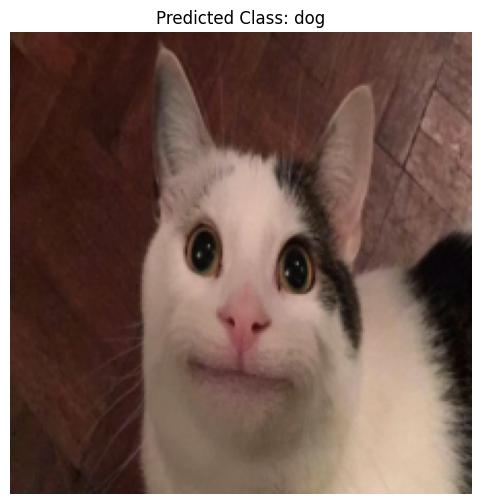

Class Probabilities:
airplane: 0.0002
automobile: 0.0040
bird: 0.0370
cat: 0.0329
deer: 0.0106
dog: 0.8746
frog: 0.0231
horse: 0.0098
ship: 0.0069
truck: 0.0008


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 이미지 전처리 정의
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 원본 이미지를 시각화하기 위한 전처리
transform_display = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 이미지 예측 함수
def predict_image(model, image_path):
    model.eval()  # 모델을 평가 모드로 설정

    # 이미지 불러오기 및 전처리
    image = Image.open(image_path)
    image_tensor = transform_image(image).unsqueeze(0).to(device)  # 배치 차원을 추가하고 디바이스로 이동

    # 예측 수행
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = nn.functional.softmax(outputs, dim=1)  # 소프트맥스 적용하여 확률 계산
        _, predicted = torch.max(outputs, 1)

    return image, predicted.item(), probabilities.cpu().numpy()

# CIFAR-10 클래스 레이블
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 예측 예제
image_path = '/kaggle/input/catttt/NISI20230712_0001313626_web.jpg'  # 예측할 이미지 경로
image, predicted_class, probabilities = predict_image(model, image_path)

# 이미지 출력
plt.figure(figsize=(8, 6))
plt.imshow(transform_display(Image.open(image_path)).permute(1, 2, 0).numpy())
plt.title(f"Predicted Class: {cifar10_classes[predicted_class]}")
plt.axis('off')
plt.show()

# 예측 확률 출력
print("Class Probabilities:")
for i, prob in enumerate(probabilities[0]):
    print(f"{cifar10_classes[i]}: {prob:.4f}")
